# **Timeseries Topic Modeling**

In [1]:
import datetime
# import tweepy
import sys
import pandas as pd
import numpy as np
import re
import pythainlp
import matplotlib.pyplot as plt
import seaborn as sns
from pythainlp.tokenize import word_tokenize
import gensim
from gensim.corpora import Dictionary
import wget
from sklearn.preprocessing import MinMaxScaler

In [3]:
# !python -m wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [2]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [3]:
import graphviz

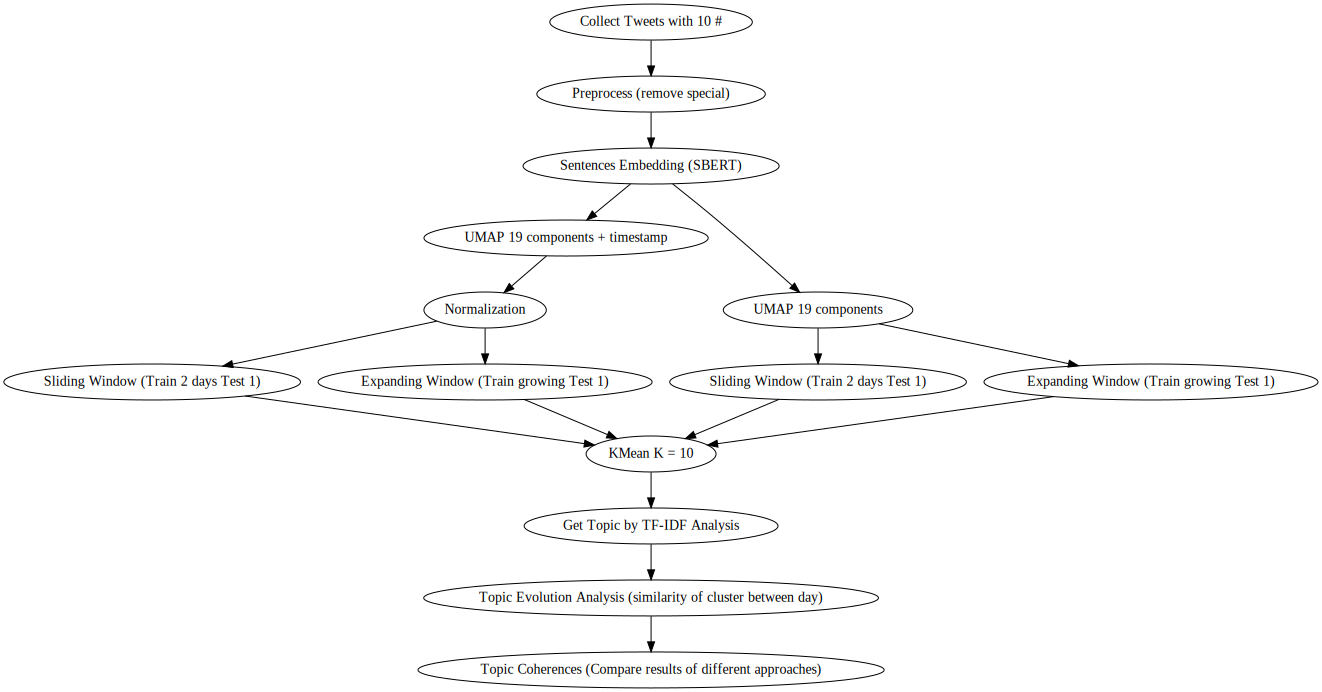

In [4]:
#| output: true
dot = graphviz.Digraph('round-table', comment='The Round Table')  
dot.node('A', 'Collect Tweets with 10 #')  
dot.node('B', 'Preprocess (remove special)')
dot.node('C', 'Sentences Embedding (SBERT)')
dot.node('D', 'UMAP 19 components + timestamp')
dot.node('E', 'Normalization')
dot.node('F', 'Sliding Window (Train 2 days Test 1)')
dot.node('G', 'Expanding Window (Train growing Test 1)')


dot.node('L', 'UMAP 19 components')
dot.node('M', 'Sliding Window (Train 2 days Test 1)')
dot.node('N', 'Expanding Window (Train growing Test 1)')

dot.node('H', 'KMean K = 10')
dot.node('J', 'Get Topic by TF-IDF Analysis ')
dot.node('U', 'Topic Evolution Analysis (similarity of cluster between day)')
dot.node('K', 'Topic Coherences (Compare results of different approaches)')

dot.edges(['AB', 'BC', 'CD','CL', 'DE', 'EF', 'EG', 'FH', 'GH', 'HJ', 'JU', 'UK', 
           'LM', 'LN', 'MH', 'NH'])
# dot.edge('B', 'L', constraint='false')
dot

## **Preparation**

In [5]:
# import gdown

In [6]:
# !gdown 12ErWhbUMPkS1esrTEVzOgS8AupPTRgFL
# gdown.download(id = '12ErWhbUMPkS1esrTEVzOgS8AupPTRgFL')

In [7]:
# gdown.download(id = '1p605F7e8er3SIzc8Bm5cMw7a4V1oXd2L')
# !gdown 1p605F7e8er3SIzc8Bm5cMw7a4V1oXd2L

In [5]:
new_df = pd.read_csv('../senior2/tweets48458.csv')

In [6]:
new_df[['text', 'timestamp', 'hashtag']].head()

,text,timestamp,hashtag
0,ขั้นตอนการรับง่ายเพียงแค่นี้\n1.รีทวิต\n2.กดหัวใจ\n3.แคปโพสให้แอดมิน\n\nติดต่อแอดมิน : https://t.co/E8392Xy24w\n\n#MILLI #เด็ก18ฆ่าเด็ก13 #วาคานด้าจงเจริญ #แฉxVIVSKINอิงฟ้า #คุณชายEP12 #saveG #PunBNK48 #BlackPanther #OMEGAThailand #NONTTANONT #สล็อต #สล็อตออนไลน์ #บาคาร่า #หวย https://t.co/lAaQ1EyXrJ,2022-11-09 16:37:51+00:00,#เด็ก18ฆ่าเด็ก13
1,รับ #ดูดวงจีน (ใช้วันเดือนปีเกิด เวลาเกิด และเพศ)ประกอบกับ ไพ่ยิปซี+หินรูน\n\nคำถามละ 24 บาท\n\n4 คำถาม 80 บาท\n\nพื้นดวง 88 บาท\n\nพื้นดวง+คำถาม พิมพ์ 184/คอล 264 บาท \n\nดูรีวิวได้ที่ #ทนายดูดวง\n\n#ดูดวง #ดูดวงไพ่ยิปซี #ดูดวงแม่นๆ #ดูดวงการเรียน #เด็ก18ฆ่าเด็ก13 #อิงฟ้ามหาชน https://t.co/2g064Q4wLv,2022-11-09 16:34:31+00:00,#เด็ก18ฆ่าเด็ก13
2,โปรสำหรับสมาชิก B2YCLUB\nได้ทั้งเก่า และ ใหม่ รับยอดปังๆ\n\nฝาก 1 บาท รับเพิ่มอีก 49 ทันที\n\nสมัครแอดไลน์ &gt;&gt;&gt;https://t.co/vpIGYiBQq0\n\nหรือ \n@byy123\n\n💘&gt;รีทวิต กดใจ กดติดตาม💘&lt;\n\n#เครดิตฟรีล่าสุด #เครดิตฟรีล่าสุดวันนี้ #เครดิตฟรีได้จริง #เด็ก18ฆ่าเด็ก13 #ลอยกระทง #ออฟกัน #ทุนฟรี https://t.co/LrPgqrwFeP,2022-11-09 16:31:53+00:00,#เด็ก18ฆ่าเด็ก13
3,▪️สมัคร 100 รับเพิ่ม 50 \n▪️ฝาก-ถอน อัตโนมัติ ไม่มีขั้นต่ำ\n\n📲 สมัครฟรี &gt;&gt;&gt; https://t.co/GLGDEauaro\n\n#ไม่ต้องฝากก่อน\n#เครดิต50 #ทุนฟรีไม่ต้องฝากก่อน\n#เว็บตรง #เด็ก18ฆ่าเด็ก13 https://t.co/lvk2jXTR1S,2022-11-09 16:31:02+00:00,#เด็ก18ฆ่าเด็ก13
4,สันดาน : เยี่ยม\nชูวิทย์ : เยี่ยมพ่อมึงอะดิ\n#ชูวิทย์ #สันธนะ #เด็ก18ฆ่าเด็ก13 https://t.co/exuKJ8USvG,2022-11-09 16:30:39+00:00,#เด็ก18ฆ่าเด็ก13


In [7]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp']).dt.tz_localize(None)

In [8]:
new_df.sort_values(by = 'timestamp', inplace = True)

Data date range

In [9]:
#| output: true
new_df['timestamp'].min(), new_df['timestamp'].max()

(Timestamp('2022-11-03 16:12:47'), Timestamp('2022-11-09 16:37:51'))

In [10]:
new_df = new_df.reset_index(drop = True)

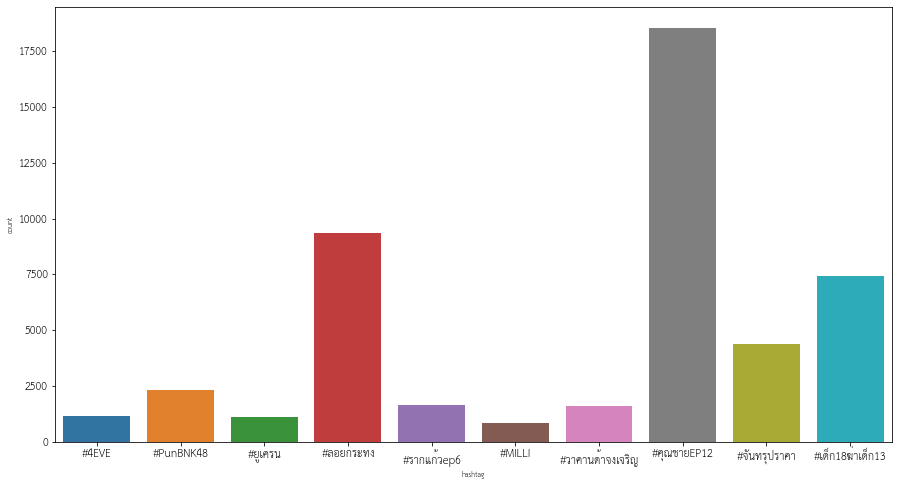

In [11]:
#| output: true
plt.figure(figsize=(15,8))
sns.countplot(data = new_df, x = 'hashtag')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [14]:
new_data = new_df['text'].to_list()

In [15]:
def remove_special(sentence, output_option = "list"):
    
    sentence = str(sentence)
    pattern = re.compile(r"[^\u0E00-\u0E7F' ]|^'|'$|''")   
    stopwords_th = pythainlp.corpus.common.thai_stopwords()

    char_to_remove = re.findall(pattern, sentence)

    list_with_char_removed = [char for char in sentence if not char in char_to_remove]
    # remove number but not word that contains number
    cleantext = [w for w in list_with_char_removed if not w.isnumeric()]
    cleantext = [w for w in cleantext if not w.isspace()]
    cleantext = [w for w in cleantext if not w in stopwords_th]

    # print("Clean Text:", cleantext)
    cleantext = ''.join(cleantext)

    cleantext = word_tokenize(cleantext, engine="newmm")
    cleantext = [w for w in cleantext if len(w) > 1]

    # print(cleantext)
    # print("-")

#     print(cleantext)
#     cleantext = [w for w in cleantext if not w.isnumeric()]
#     cleantext = [w for w in cleantext if not w.isspace()]

    if output_option == "list":
        return cleantext
    elif output_option == "text":
        return "".join(cleantext)

In [16]:
preprocess_tweets_list = list(map(remove_special, new_data))

In [17]:
preprocess_tweets = ["".join(text) for text in preprocess_tweets_list]

In [18]:
preprocess_tweets[:10]

['รับกดบัตรน้าค่ากดโซนโซนแวะไปดูรีวิวเค้าได้ที่รีวิวมะลิรับกดบัตรกดไม่ได้คืนเงินแน่นอนค่าเค้ารับไม่เยอะนะคะดีเอมมาจองได้เลยค่ะไม่ต้องจ่ายมัดจำก่อนค่ะ',
 'จัดไปปปเพื่ออาปัง',
 'รบกวนทางค่ายพิจาราสำหรับคอนเดี่ยวของอีกรอบนะคะส่วนใหญ่โปสเตอร์เขาให้ทุกบัตรเลยค่ะแล้วสิทธ์อื่นมีกันอีกเยอะมากอยากให้ลองซื้อใจกันอีกครั้งนะคะคอนเดี่ยวคอนแรกมันสำคัญมากจริงนะ',
 'น้องนาวหรือน้องปัญละนี่',
 'น้องนาวน่ารัก',
 'น้องนาวแจ้โอ้',
 'ปัญเนยคลิปนี้แรงมากกกกกราบน้องมีนนปัญเนย',
 'ขอบคุน้องมีนค่าาากรี้ดดดดมุมนี้แฮมากกกกกกกกน้องมีนทพจรรรรรปัญเนย',
 'อยู่ยูเนี่ยกันต่อวันที่นะคะทุกคน',
 'เราจะนอนที่ยูเนี่ยกันต่อไปเย้']

### **Sentence Embedding**

In [19]:
# !pip install sentence_transformers

In [32]:
#| echo: true
#| code-fold: false
from sentence_transformers import SentenceTransformer

In [33]:
#| echo: true
#| code-fold: false
model = SentenceTransformer('mrp/simcse-model-roberta-base-thai')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/677 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/356 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [65]:
#| echo: true
#| code-fold: false
tweets_transformed = model.encode(preprocess_tweets)

[[ 0.23238638 -0.5351743   0.15057757 ...  1.6787773   0.48718566
  -0.11669814]
 [-1.1322632  -0.09056436 -0.10341646 ...  0.29067546 -0.11151303
   1.0586742 ]
 [-0.8502812   0.05491367  0.19315858 ...  1.4432793   0.3564428
  -0.88288414]
 ...
 [ 0.12571698 -0.51505345  0.38516095 ...  0.64296293 -0.24798742
  -0.7370633 ]
 [ 0.12571698 -0.51505345  0.38516095 ...  0.64296293 -0.24798742
  -0.7370633 ]
 [ 0.12571698 -0.51505345  0.38516095 ...  0.64296293 -0.24798742
  -0.7370633 ]]


In [66]:
tweets_transformed.shape

(48459, 768)

In [67]:
# save vectors to .txt file
np.save("tweets", tweets_transformed)

In [73]:
### **Save your time by starting from here (skip sentence embedding but loading dataframe is still require)**

In [45]:
# !gdown 1Y28HdN5_dwNFz4QKYbpXBl5VdbyJnMYZ

In [44]:
# !gdown 1-t2MAwL3V5LxK7gTcaeGZb0ZmtY-tqVB

In [20]:
tweets_transformed = np.load('tweets2.npy')

In [21]:
tweets_transformed.shape

(48459, 768)

In [23]:
tweets_transformed[0][:10]

array([ 0.23238638, -0.5351743 ,  0.15057757,  0.07510338, -1.1435342 ,
        0.22358342,  0.49134043, -0.17454754,  0.27931336,  0.901894  ],
      dtype=float32)

### **Bag-of-Word**

use in topic coherences calculatation

In [24]:
from gensim.corpora import Dictionary

In [25]:
dictionary_tweets2 = Dictionary(preprocess_tweets_list)

adding document #0 to Dictionary(0 unique tokens: [])
adding document #10000 to Dictionary(10709 unique tokens: ['กด', 'ก่อน', 'คืนเงิน', 'ค่ะ', 'ค่า']...)
adding document #20000 to Dictionary(13411 unique tokens: ['กด', 'ก่อน', 'คืนเงิน', 'ค่ะ', 'ค่า']...)
adding document #30000 to Dictionary(15517 unique tokens: ['กด', 'ก่อน', 'คืนเงิน', 'ค่ะ', 'ค่า']...)
adding document #40000 to Dictionary(17476 unique tokens: ['กด', 'ก่อน', 'คืนเงิน', 'ค่ะ', 'ค่า']...)
built Dictionary(18897 unique tokens: ['กด', 'ก่อน', 'คืนเงิน', 'ค่ะ', 'ค่า']...) from 48459 documents (total 1112915 corpus positions)


In [51]:
# tweets_corpus = [dictionary_tweets.doc2bow(doc) for doc in preprocess_flood_list]

# **Modeling**

## **UMAP**

In [30]:
# !pip install umap-learn

In [26]:
import umap.umap_ as umap

In [27]:
#| echo: true
def add_timestamp(df, embedded, timestamp = True):
    # add umap
    trans = umap.UMAP(n_components = 19).fit(embedded)
    # print(embedded.shape)
    umap_embedded = trans.transform(embedded)
    # umap_embedded = embedded
    
    if timestamp:
      df['timestamp'] = pd.to_datetime(df['timestamp'])
      unix_timestamp = [t.value // 10 ** 9 for t in df['timestamp']]
      unix_timestamp = np.array(unix_timestamp).reshape(-1, 1)
      timestamped = np.hstack((umap_embedded, unix_timestamp))
      return timestamped
    else:
      return umap_embedded

In [28]:
### all umap and timestamp is gonna be added in main experiment section

In [29]:
newer_embedded = add_timestamp(new_df, tweets_transformed)

KeyboardInterrupt: 

In [ ]:
newer_embedded[0]

## **KMeans**

In [30]:
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit

### **Datetime Split**

In [33]:
date_list = []

for datetime in new_df['timestamp'].unique():
    date = str(datetime).split('T')[0]
    # print(date)
    if date not in date_list:
        date_list.append(date)
        
date_list.sort()

In [34]:
date_list

['2022-11-03',
 '2022-11-04',
 '2022-11-05',
 '2022-11-06',
 '2022-11-07',
 '2022-11-08',
 '2022-11-09']

In [35]:
import datetime

In [36]:
def TimeSpliting(df, date_list, index, approach = 'sliding'):
    """ Sliding Window Only Training Data. """
    
    # start_train = datetime.datetime.fromisoformat(date_list[index])
    # end_train = datetime.datetime.fromisoformat(date_list[index + 2])
    start_train = np.datetime64(date_list[index])
    end_train = np.datetime64(date_list[index + 2])
    
    # print(start_train)
    # print(end_train)
    # print('00000')
    
    if (index + 3 == len(date_list)):
        end_test = end_train
        cond_test = (df['timestamp'] >= end_test)
        
    else:
        end_test = np.datetime64(date_list[index + 3])
        cond_test = ((df['timestamp'] >= end_train) & (df['timestamp'] < end_test))
        
    
    if approach == 'expanding':
        train_df = df[df['timestamp'] < end_train].sort_values(['timestamp'], ascending = True)
    else: 
        train_df = df[(df['timestamp'] >= start_train) & (df['timestamp'] < end_train)].sort_values(['timestamp'], ascending = True)
    # train_df = train_df.dropna(subset = ['text', 'timestamp']).reset_index(drop = True)
    
    test_df = df[cond_test].sort_values(['timestamp'], ascending = True)
    # test_df = test_df.dropna(subset = ['text', 'timestamp']).reset_index(drop = True)
    
    return train_df, test_df

In [45]:
def actual_time_topicmodel(data_embedded: np.array, data_df: pd.DataFrame, original_data: list, kmean_model, approach = 'sliding'):
    date_list = []

    for datetime in data_df['timestamp'].unique():
        date = str(datetime).split('T')[0]

        if date not in date_list:
            date_list.append(date)

    date_list.sort()
    
    rep = 1
    results = {}
    for index in range(len(date_list) - 2):
        train_df, test_df = TimeSpliting(data_df, date_list, index, approach)
        X_train = data_embedded[train_df.index]
        X_test = data_embedded[test_df.index]
        print(index)
        # print(train_df.index, test_df.index)
        
        kmean = kmean_model.fit(X_train)

        # append cluster center of each fold for similarities
        # cluster_centers.append(kmean.cluster_centers_)

        # test set prediction
        prediction = kmean.predict(X_test)

        temp_data = np.array(original_data)[test_df.index]
        results[str(rep)] = pd.DataFrame({'text': temp_data, 'prediction': prediction})
        
        rep += 1
    return results

#### **Plot Split Approches**

In [39]:
def plot_cv_indices(cv, X, y, ax, n_splits, title, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        # print(ii)
        ax.scatter(
            range(len(indices)),
            [ii] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits),
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        # ylim=[n_splits + 2.2, -0.2],
        # xlim=[0, 100],
    )
    ax.set_title(f"{title}", fontsize=15)
    return ax

In [44]:
#| echo: true
def timeseries_topicmodel(data_embedded: np.array, original_data: list, fold_number: int, kmean_model, split_mode = 'expanding'):
    """
    data_embedded: sentences embedded data 
    original_data: list of sentences
    fold_number: number of fold to split
    kmean_model: configured Kmean model
    split_mode: Sliding window or Expanding window approach
    """
    # tscv = TimeSeriesSplit(n_splits = fold_number)
    if split_mode == 'sliding':
        tscv = TimeSeriesSplit(n_splits = fold_number, max_train_size= int(data_embedded.shape[0] * 0.3))
        # print(int(data_embedded.shape[0] * 0.3))
    if split_mode == 'expanding':
        tscv = TimeSeriesSplit(n_splits = fold_number)
    rep = 1
    cluster_centers = []
    results = {}
    for train_index, test_index in tscv.split(data_embedded):
        X_train = data_embedded[train_index]
        X_test = data_embedded[test_index]

        kmean = kmean_model.fit(X_train)

        # append cluster center of each fold for similarities
        cluster_centers.append(kmean.cluster_centers_)

        # test set prediction
        prediction = kmean.predict(X_test)

        temp_data = np.array(original_data)[test_index]
        results[str(rep)] = pd.DataFrame({'text': temp_data, 'prediction': prediction})
        rep += 1

    return cluster_centers, results

In [36]:
# center_slide, result_slide_temp = timeseries_topicmodel(flood_embedded, preprocess_flood, 7, kmean_model = KMeans(n_clusters=10, random_state=0), split_mode = 'sliding')

In [37]:
# center_expand, result_expand_temp = timeseries_topicmodel(flood_embedded, preprocess_flood, 7, kmean_model = KMeans(n_clusters=10, random_state=0), split_mode = 'expanding')

### **Main Experiments**

In [41]:
#| echo: true
def model_topic(df, transformed_data, preprocessed_data, use_timestamp: bool, approach = 'sliding'):
    embedded = add_timestamp(df, transformed_data, timestamp = use_timestamp)
    if use_timestamp:
        embedded = MinMaxScaler().fit_transform(embedded)
    centers, results = timeseries_topicmodel(embedded, preprocessed_data, 7, 
                                          kmean_model = KMeans(n_clusters=10, random_state=0), 
                                          split_mode = approach)
    return results

<font color = "red">Sliding Window Train 2 days Test 1 day</font>

<font color = "red">Expanding Window Train growing and Test 1 day</font>

In [43]:
def model_topic2(df, transformed_data, preprocessed_data, use_timestamp: bool, approach = 'sliding'):
    embedded = add_timestamp(df, transformed_data, timestamp = use_timestamp)
    if use_timestamp:
        embedded = MinMaxScaler().fit_transform(embedded)
    results = actual_time_topicmodel(embedded, df, preprocessed_data, 
                                          kmean_model = KMeans(n_clusters=10, random_state=0), 
                                          approach = approach)
    return results

In [115]:
#| output: true
# fig, ax = plt.subplots(figsize = (10, 5))
# plot_cv_indices(tscv_test, tweets_transformed, tweets_transformed, ax, 7, title = 'Sliding Window Approach')
# plt.show()

In [119]:
#| output: true
# fig, ax = plt.subplots(figsize = (10, 5))
# tscv_expanding = TimeSeriesSplit(n_splits = 7)
# plot_cv_indices(tscv_expanding, tweets_transformed, tweets_transformed, ax, 7, title = 'Expanding Approach')
# plt.show()

In [50]:
#| echo: true
#| code-fold: false
# time not related modeling
result_normal_slide = model_topic2(new_df, tweets_transformed, preprocess_tweets, False, 'sliding')
result_normal_expand = model_topic2(new_df, tweets_transformed, preprocess_tweets, False, 'expanding')

0
1
2
3
4
0
1
2
3
4


In [51]:
#| echo: true
#| code-fold: false
# time related model
result_time_slide = model_topic2(new_df, tweets_transformed, preprocess_tweets, True, 'sliding')
result_time_expand = model_topic2(new_df, tweets_transformed, preprocess_tweets, True, 'expanding')

0
1
2
3
4
0
1
2
3
4


# **TF-IDF Analysis (Topic Extraction)**

#### **TF-IDF By Class**
https://buhrmann.github.io/tfidf-analysis.html

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    # print(topn_ids)
    top_feats = [(features[i], row[i]) for i in topn_ids]
    # print(top_feats)
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [54]:
# average tf-idf score of all words across a number of documents (in this case all documents)
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [55]:
# top feature by class
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [56]:
def plot_tfidf_classfeats_h(dfs, sub_title):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(17, 8), facecolor="w")
    x = np.arange(len(dfs[0]))
    # print(x)
    for i, df in enumerate(dfs):
        # print(df.sort_values(by = 'tfidf',ascending = True))
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=13)
        ax.set_title("label = " + str(df.label), fontsize=16)
        # ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf.sort_values(ascending = True), align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature[::-1], fontsize = 14)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.92, wspace=0.52)
    fig.suptitle(sub_title, fontsize = 14)
    plt.show()

In [57]:
### **Topics Extraction**

In [58]:
#| echo: true
#| code-fold: false
def extract_topics(clustered_result: dict):
    tmp_topics = []
    for fold in clustered_result:
        tmp_data = clustered_result[fold]['text'].tolist()
        
        vectorizer = TfidfVectorizer(tokenizer = word_tokenize)
        Xtr = vectorizer.fit_transform(tmp_data)
        features = vectorizer.get_feature_names_out()
        
        kmean_y = clustered_result[fold]['prediction'].tolist()
        topics_by_class = top_feats_by_class(Xtr, kmean_y, features, top_n = 25)
        tmp_topics.append(topics_by_class)

    return tmp_topics

In [59]:
result_normal_slide.keys()

dict_keys(['1', '2', '3', '4', '5'])

In [60]:
result_normal_slide

{'1':                                                   text  prediction
 0    ลอยกระทงออนไลน์กับปีนี้ไม่ต้องออกจากบ้านเช่นเค...           5
 1    รัสเซียยูเครนทหารรัสเซียเอกการละครแกล้งตายกันเ...           0
 2    กระทรวงกลาโหมอังกฤษระบุในรายงานประจำวันเกี่ยวก...           0
 3    ลอยกระทงปีนี้ตรงกับการเกิดจันทรุปราคาเต็มดวงพอ...           5
 4    ลอยกระทงปีนี้ตรงกับการเกิดจันทรุปราคาเต็มดวงพอ...           5
 ..                                                 ...         ...
 992  กองทัพยูเครนกำลังบุกที่ไหนสักแห่งในภูมิภาคยูเค...           0
 993  จนถึงขะนี้กองกำลังรัสเซียล้มเหลวในการทำลายไม่แ...           0
 994  โรงไฟฟ้านิวเคลียร์สามารถเชื่อมต่อกับระบบพลังงา...           0
 995  เมืองภูมิภาคเขตการต่อสู้สภาพประมานี้ยูเครนรัสเ...           0
 996  รับกดบัตรเด็กน้าค่ากดใบกดหน้าเคาน์เตอร์มีทีมกด...           2
 
 [997 rows x 2 columns],
 '2':                                                   text  prediction
 0    สนามบินเชียงใหม่เปลี่ยนเวลาเที่ยวบินพเลี่ยงการ...           0
 1    สนามบ

In [61]:
#| echo: true
#| code-fold: false
# result will be list of list of dataframe store topic of each cluster
# first index will be index of the results of each day
# second index will be index of the topics of each cluster
topics_normal_slide = extract_topics(result_normal_slide)
topics_normal_expand = extract_topics(result_normal_expand)

In [62]:
#| echo: true
#| code-fold: false
topics_time_slide = extract_topics(result_time_slide)
topics_time_expand = extract_topics(result_time_expand)

## **Normal Sliding Window Topics Results**

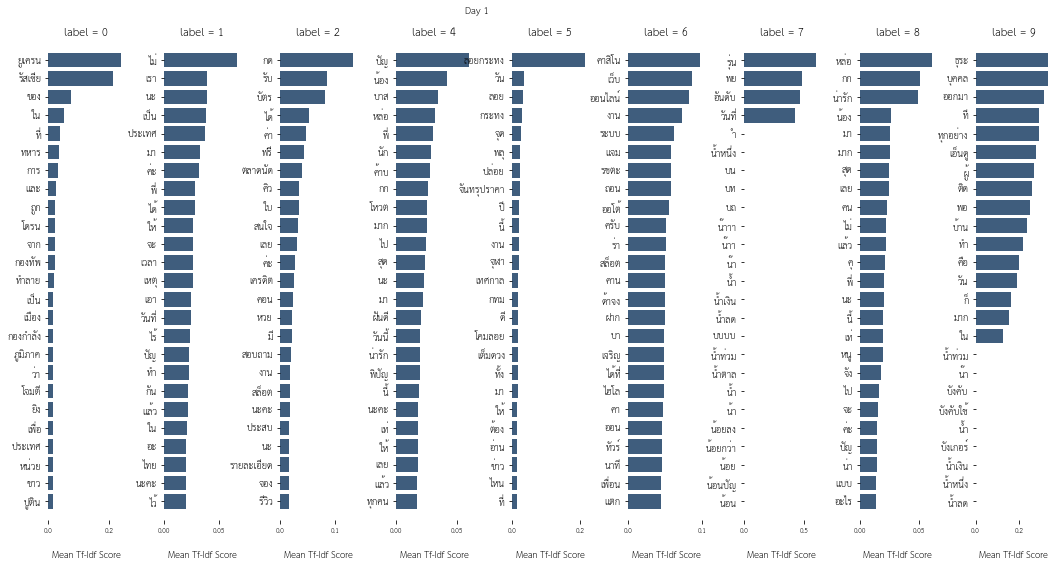

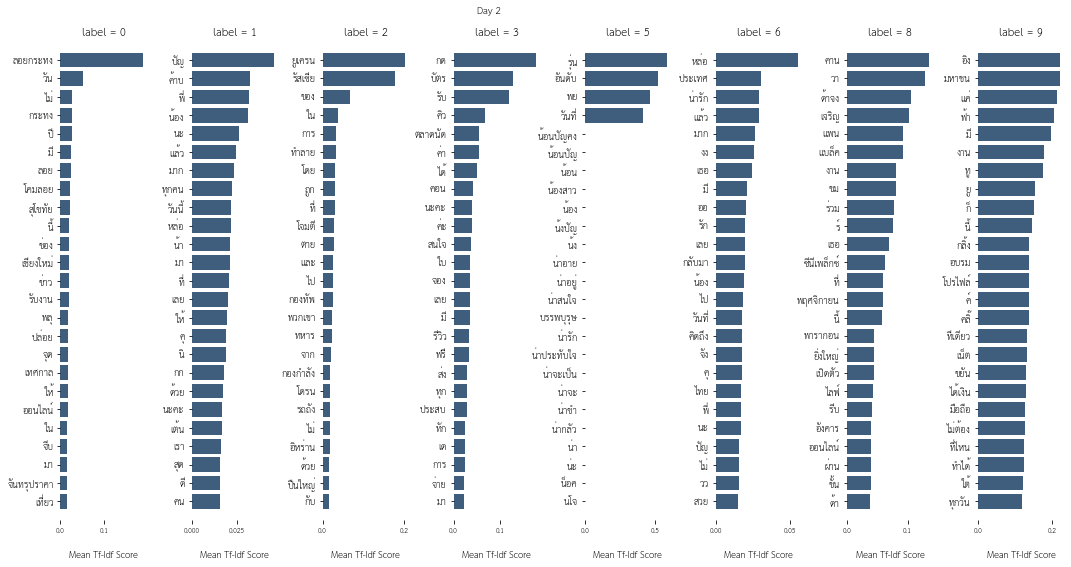

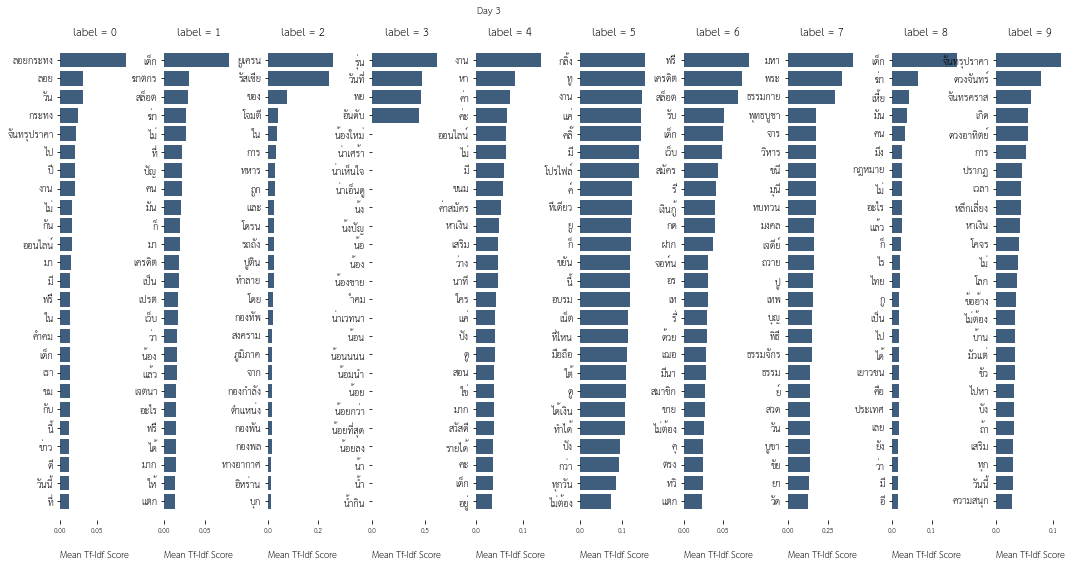

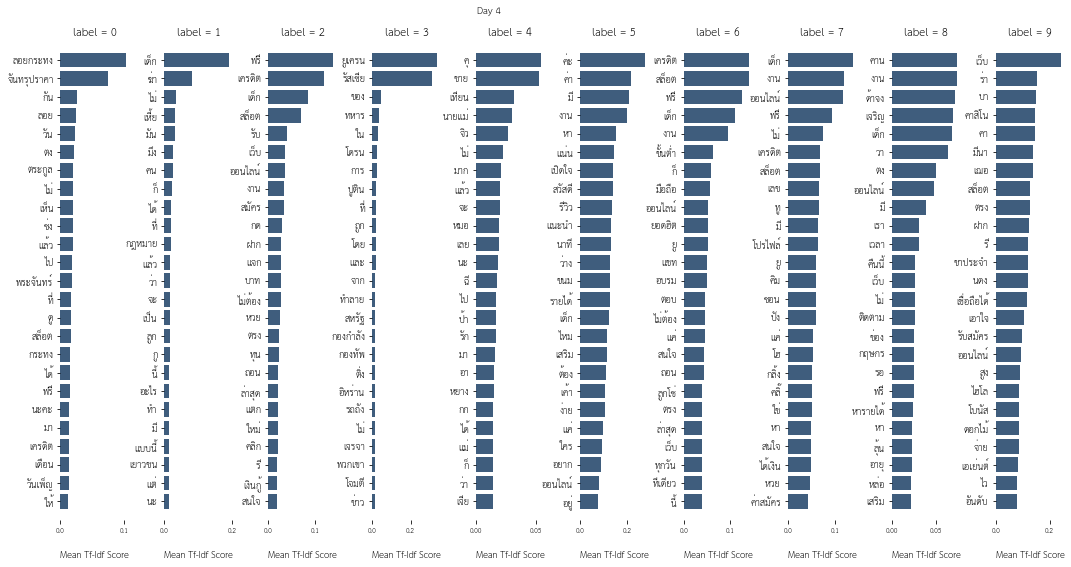

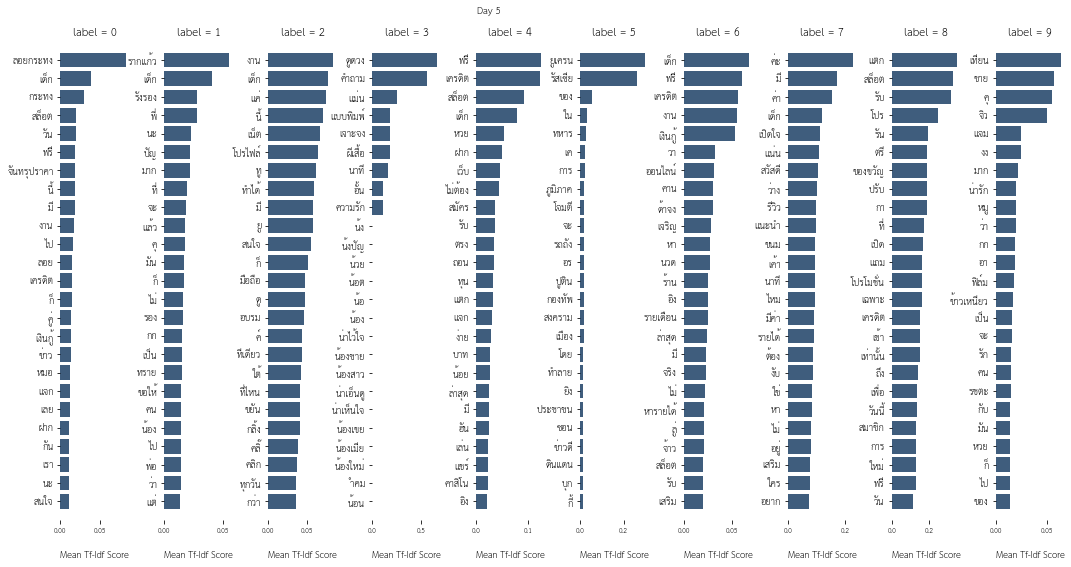

In [63]:
#| output: true
for day in range(len(topics_normal_slide)):
    plot_tfidf_classfeats_h(topics_normal_slide[day], f"Day {day + 1}")

## **Normal Expanding Window Topics Results**

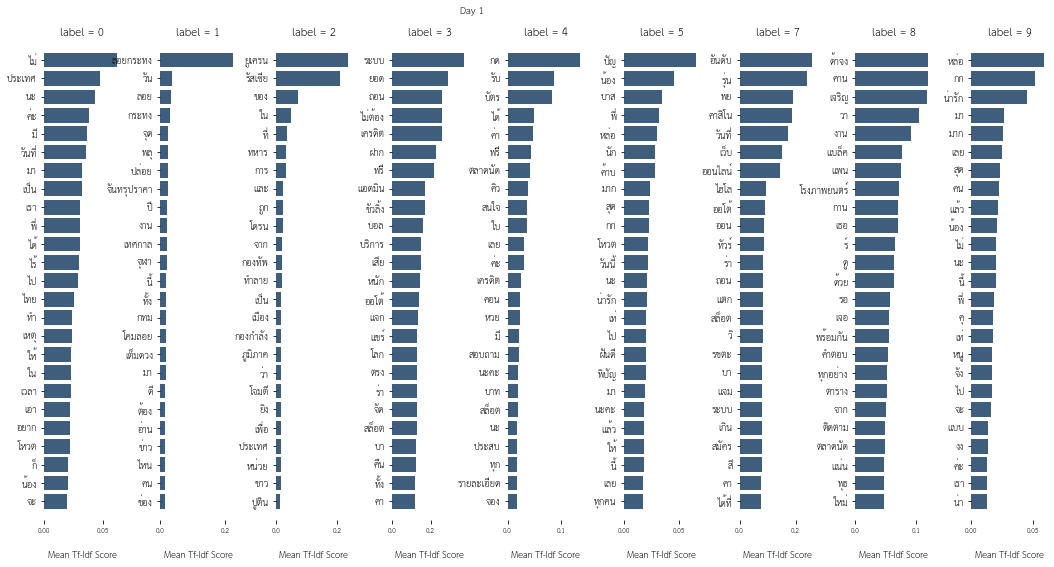

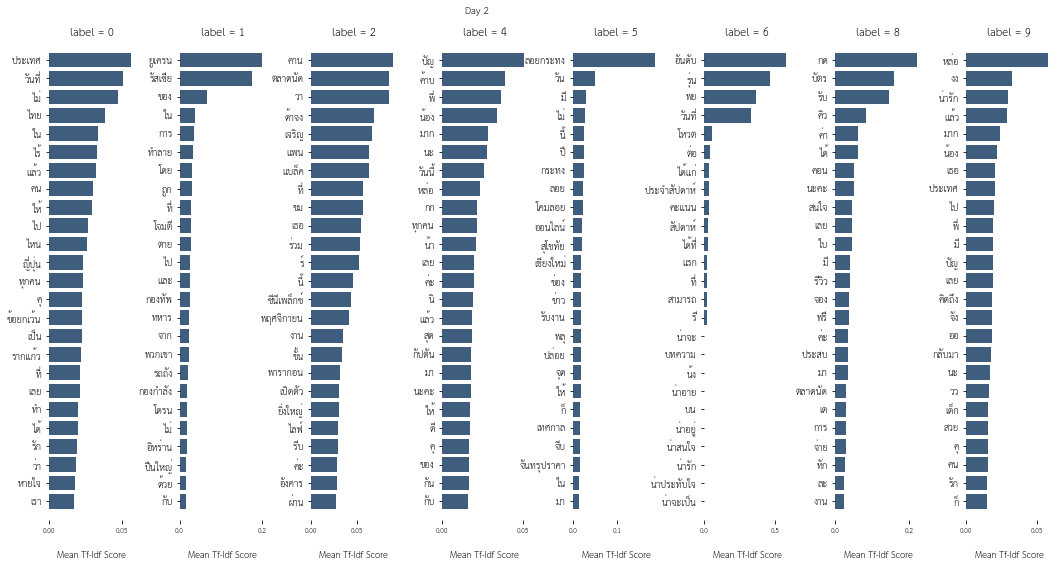

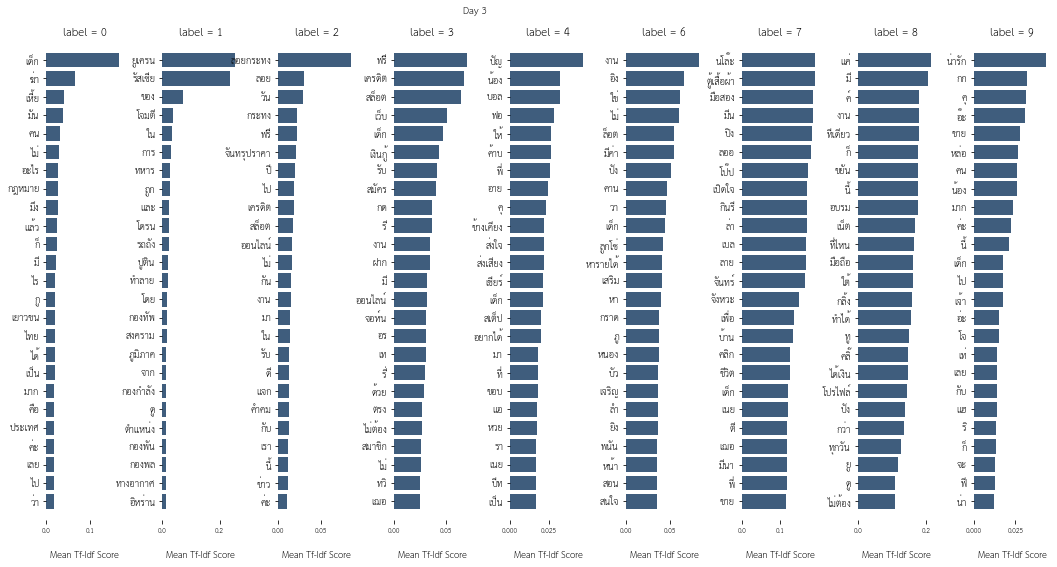

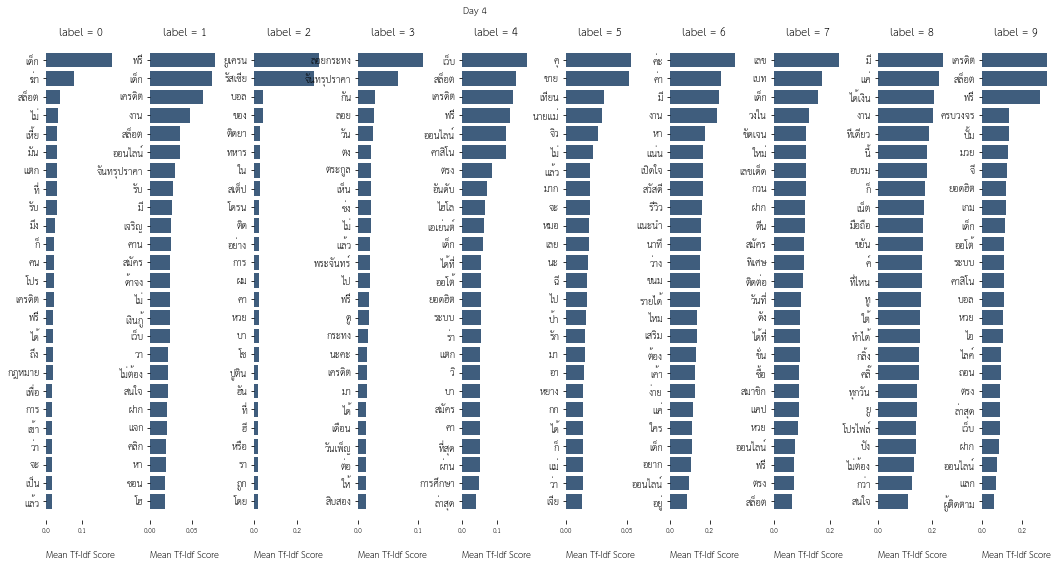

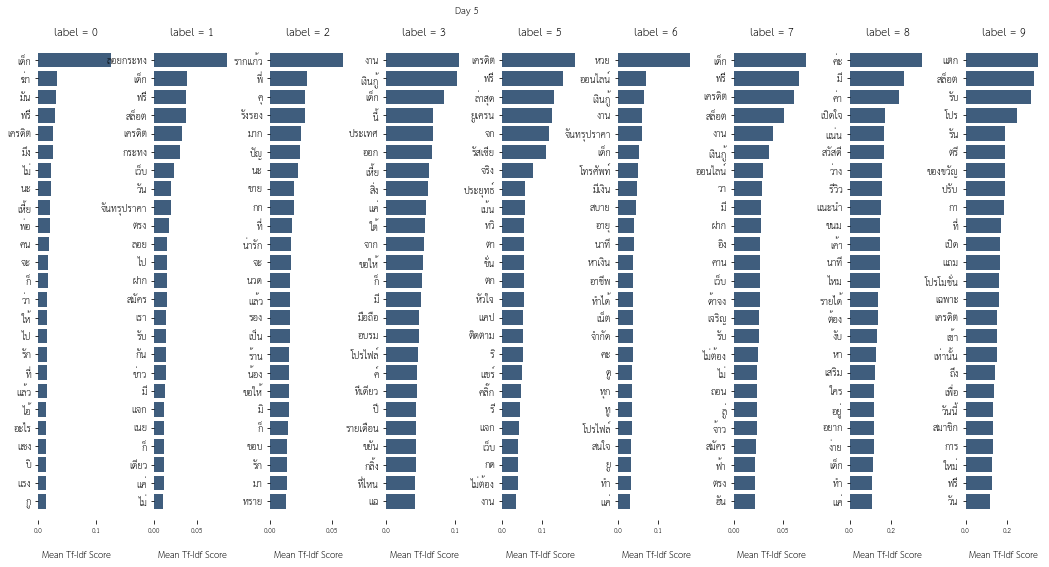

In [56]:
#| output: true
for day in range(len(topics_normal_expand)):
    plot_tfidf_classfeats_h(topics_normal_expand[day], f"Day {day + 1}")

## **Time Related Sliding Window Topics Results**

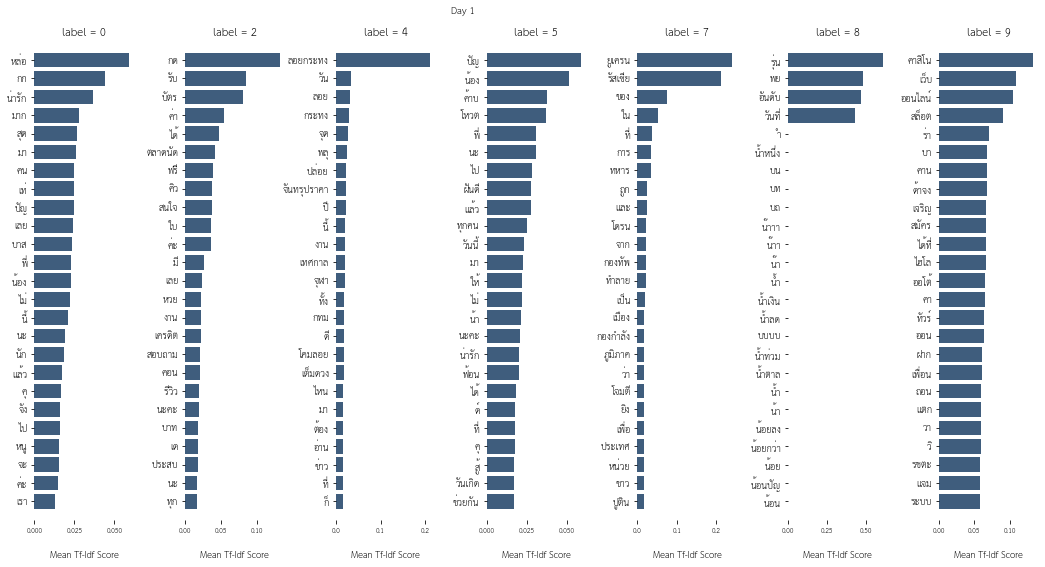

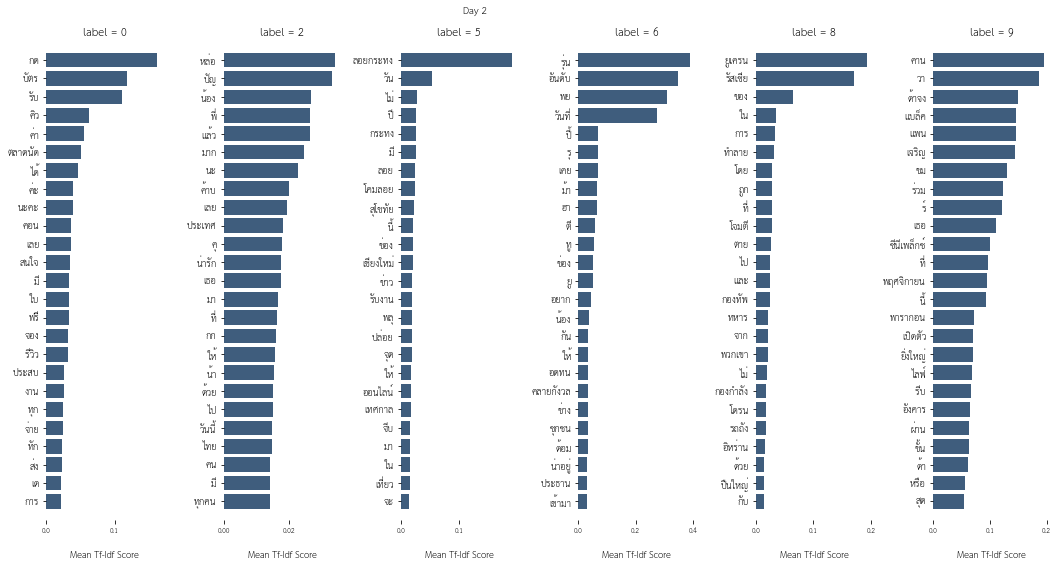

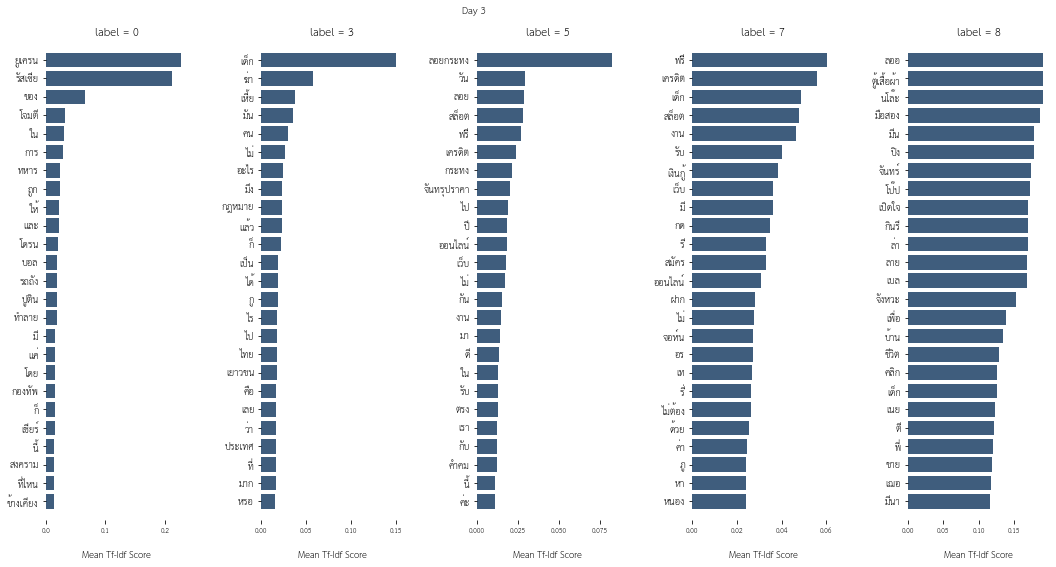

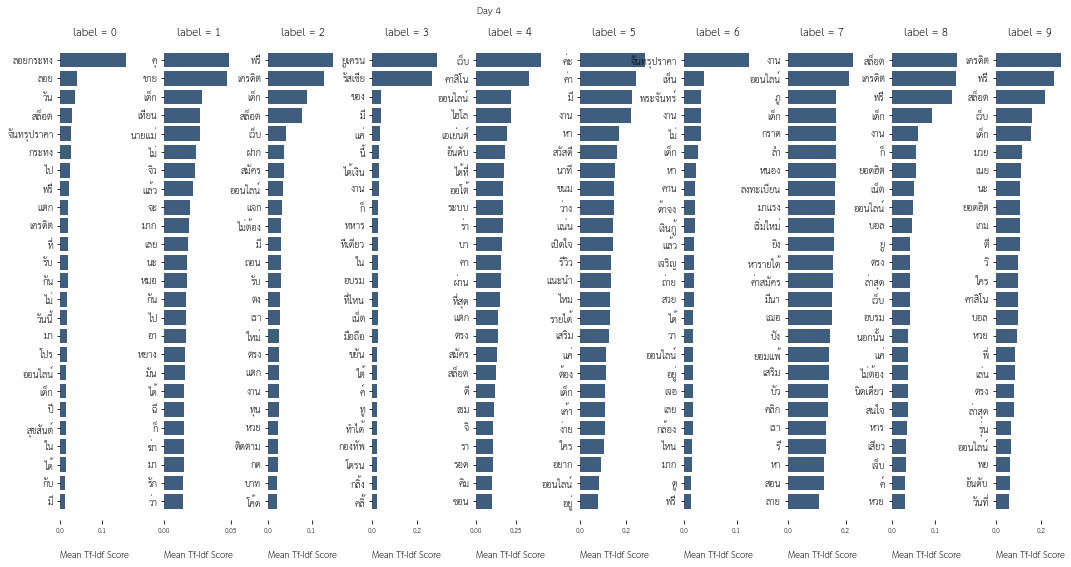

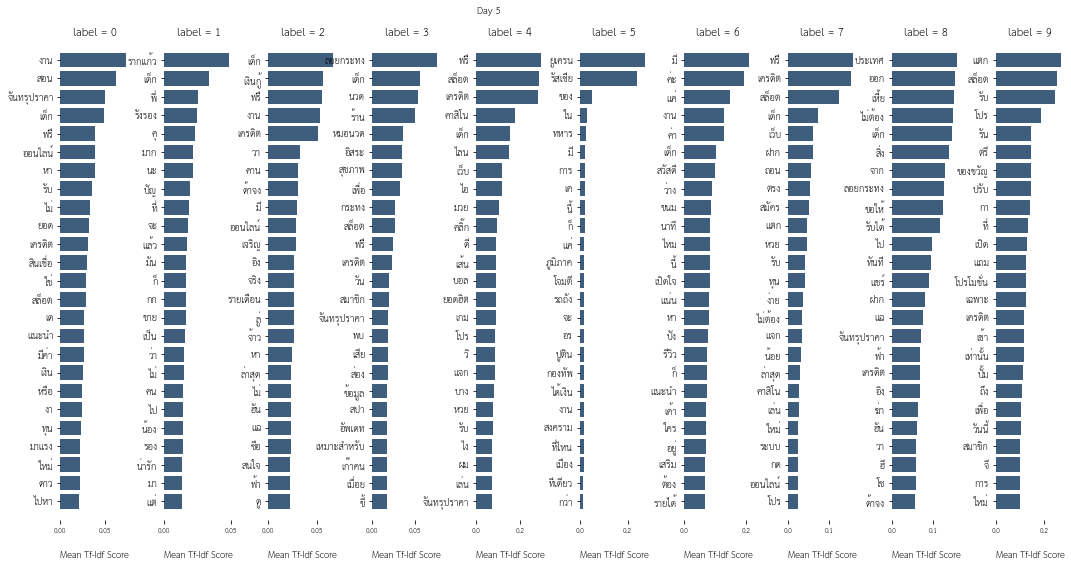

In [64]:
#| echo: true
#| code-fold: false
#| output: true
for day in range(len(topics_time_slide)):
    plot_tfidf_classfeats_h(topics_time_slide[day], f"Day {day + 1}")

## **Time Related Expanding Window Topics Results**

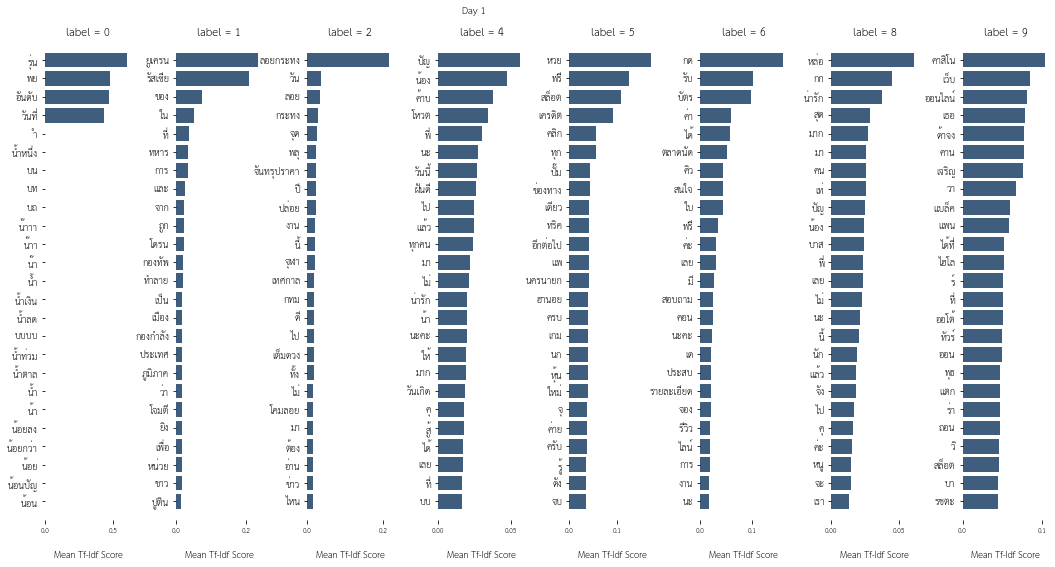

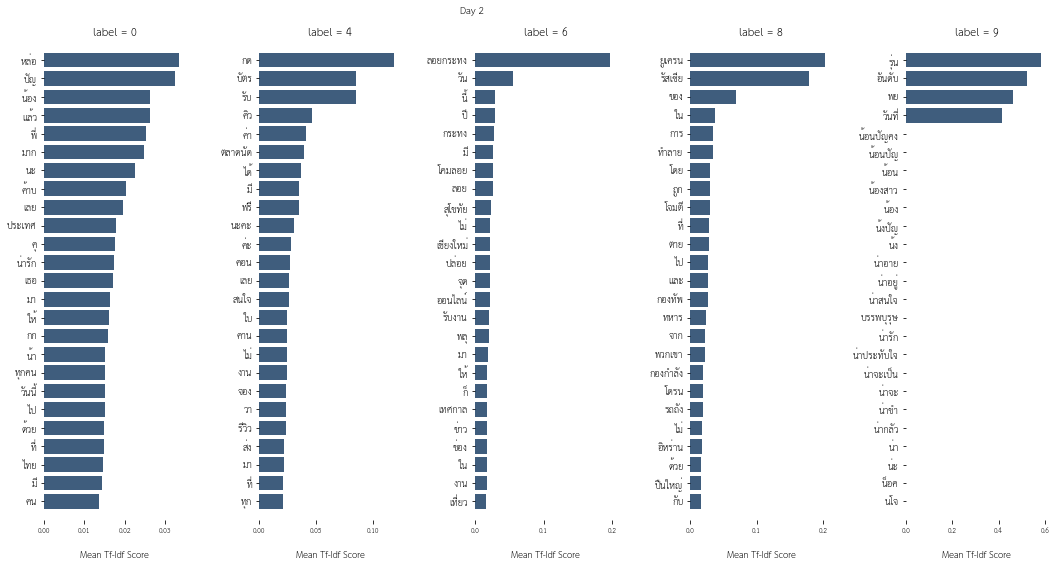

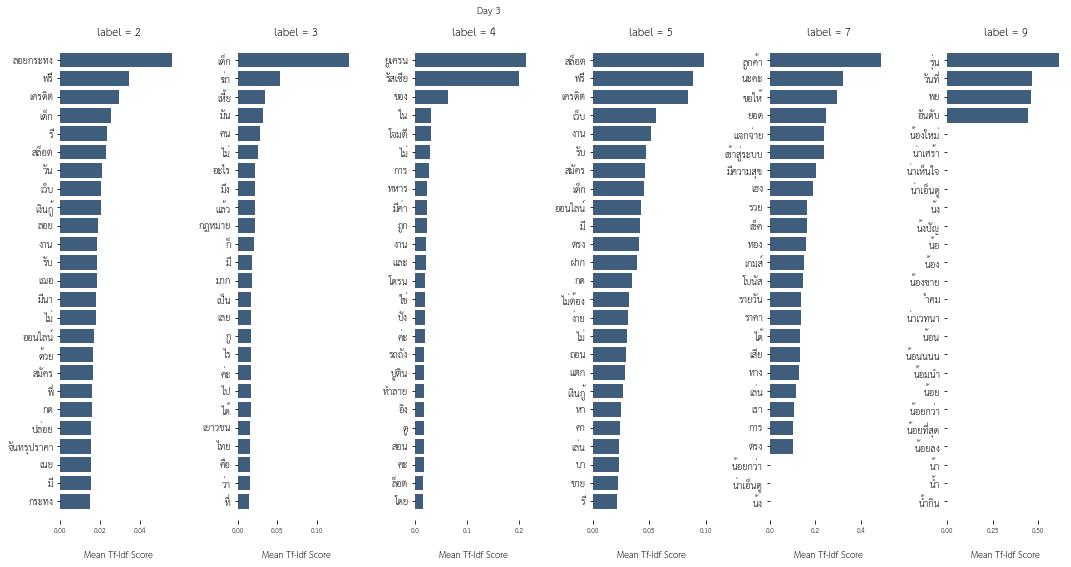

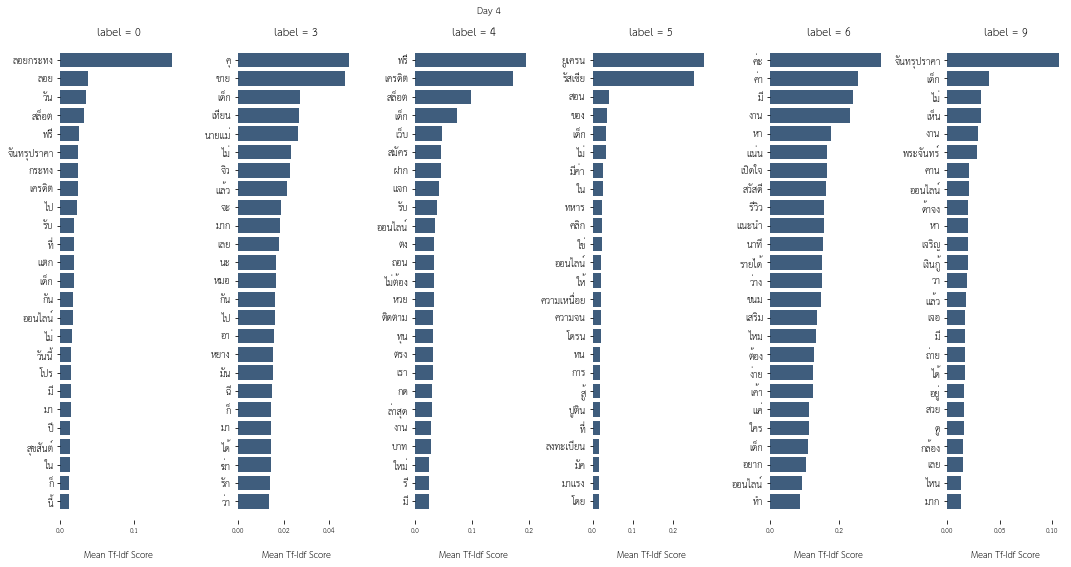

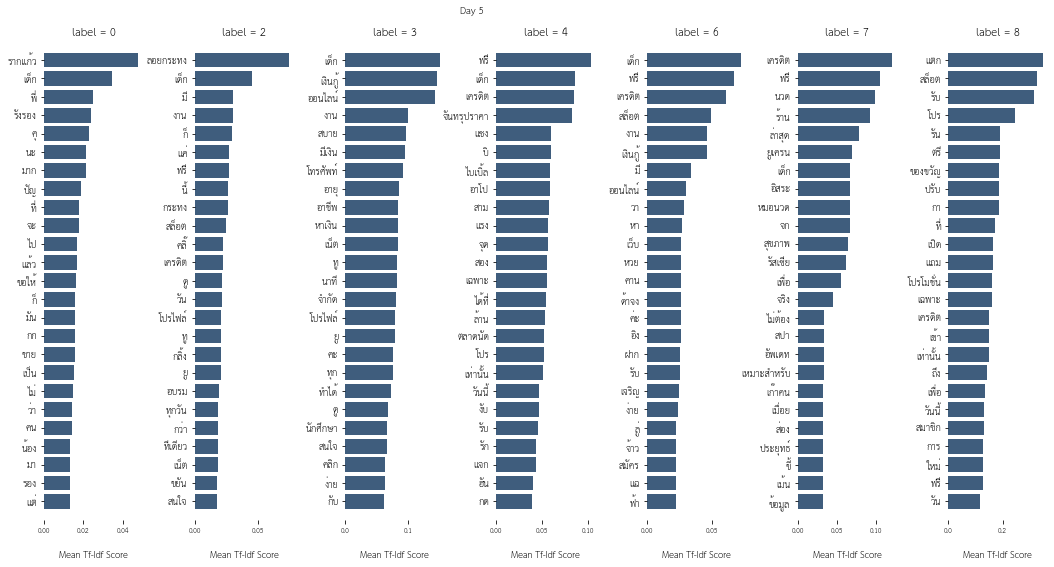

In [65]:
#| echo: true
#| code-fold: false
#| output: true
for day in range(len(topics_time_expand)):
    plot_tfidf_classfeats_h(topics_time_expand[day], f"Day {day + 1}")

# **Similarity (Topics Evolution)**

In [66]:
from sklearn.metrics.pairwise import cosine_similarity
import gensim

In [67]:
# convert list of list of data frame to list of topics
def topics_tolist(topics):
  topics_list = []
  for day in range(len(topics)):
    topics_each_day = []
    # print(len(topics[day]))
    for i in range(len(topics[day])):
      topics_each_day.append(topics[day][i]['feature'].tolist())
    topics_list.append(topics_each_day)
  return topics_list

In [68]:
normal_slide_topics_list = topics_tolist(topics_normal_slide)
normal_expand_topics_list = topics_tolist(topics_normal_expand)

In [69]:
# convert topics from DF to list
time_slide_topics_list = topics_tolist(topics_time_slide)
time_expand_topics_list = topics_tolist(topics_time_expand)

In [72]:
# transform to np.array is needed
def cal_similarity(topics_list):
  similarity_list = []
  for i in range(1, len(topics_list)):
    sim_topics = []
    for j in range(len(topics_list[i - 1])):
      corpus_temp1 = dictionary_tweets2.doc2bow(topics_list[i - 1][j])
      # need second loop for calculate similarity of every pair 
      # (1 of first topics set vs every topics of seconde set)
      topics_set2_sim = []
      for k in range(len(topics_list[i])):
        corpus_temp2 = dictionary_tweets2.doc2bow(topics_list[i][k])
        similarity = gensim.matutils.cossim(corpus_temp1, corpus_temp2)
        topics_set2_sim.append(similarity)
      sim_topics.append(topics_set2_sim)
    similarity_list.append(np.array(sim_topics))
  return similarity_list

In [73]:
sim_normal_slide = cal_similarity(normal_slide_topics_list)
sim_normal_expand = cal_similarity(normal_expand_topics_list)

In [74]:
sim_time_slide = cal_similarity(time_slide_topics_list)
sim_time_expand = cal_similarity(time_expand_topics_list)

In [75]:
def get_label(topics_list: list):
    # input is the list of dfs(topic)
    labels = []
    for label in range(len(topics_list)):
        labels.append(topics_list[label].label)
    return labels

In [76]:
def sim_heatmap(sim_matrix, labely, labelx, title: list):
    ax = sns.heatmap(sim_matrix, linewidth=0.5)
    ax.set_yticklabels(labely, fontsize = 16)
    ax.set_xticklabels(labelx, fontsize = 16)
    ax.set_xlabel(f"Day {title[1]} Cluster Label", fontsize = 15)
    ax.set_ylabel(f"Day {title[0]} Cluster Label", fontsize = 15)
    ax.set_title(f"Similarities between Day {title[0]} and {title[1]}", fontsize = 16)
    plt.show()

In [77]:
def allsim_plot(sim_set, topics_set):
    labels = []
    for day in range(len(topics_set)):
        labels.append(get_label(topics_set[day]))
    
    for date in range(len(sim_set)):
        sim_heatmap(sim_set[date], labels[date], labels[date+1], [date + 1, date + 2])

## **Normal Sliding Window Similarities**

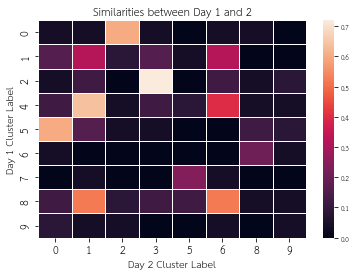

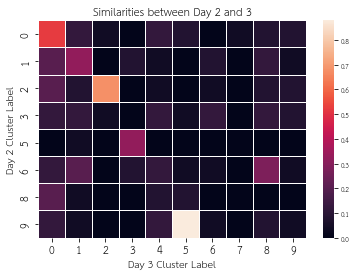

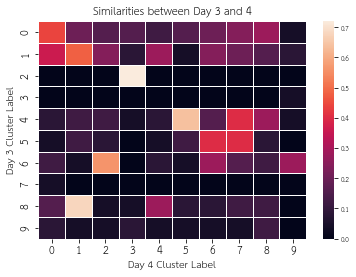

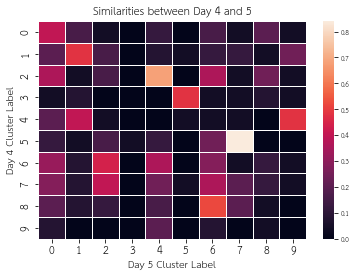

In [78]:
#| output: true
allsim_plot(sim_normal_slide, topics_normal_slide)

## **Normal Expanding Window Similarities**

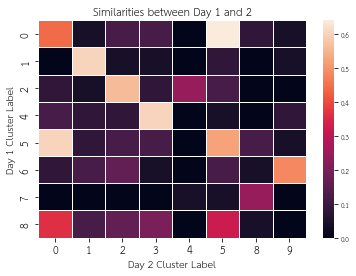

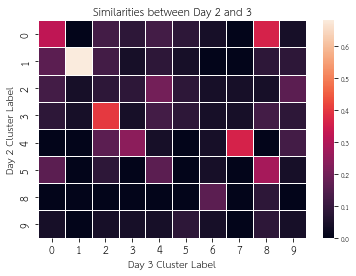

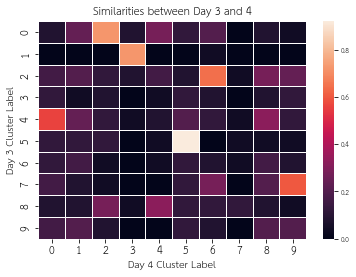

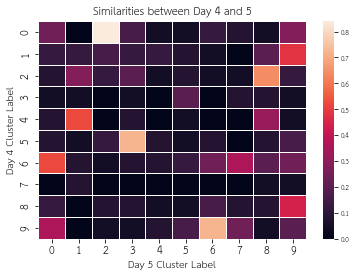

In [79]:
#| output: true
allsim_plot(sim_normal_expand, topics_normal_expand)

## **Time related Sliding Window Similarities**

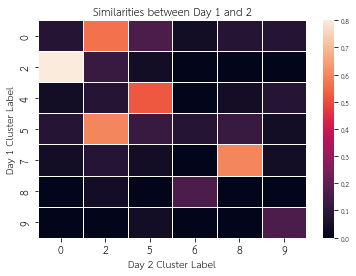

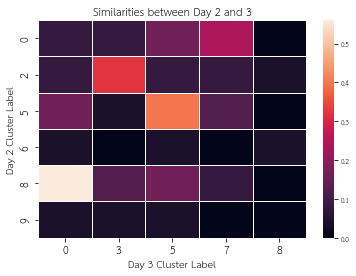

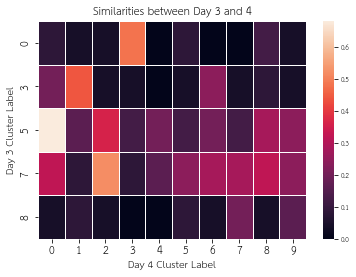

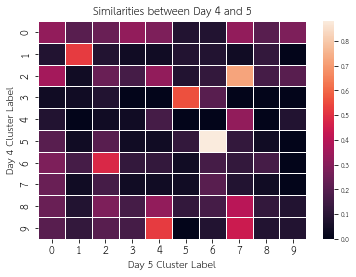

In [80]:
#| output: true
allsim_plot(sim_time_slide, topics_time_slide)

## **Time related Expanding Window Similarities**

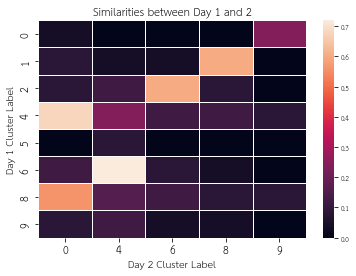

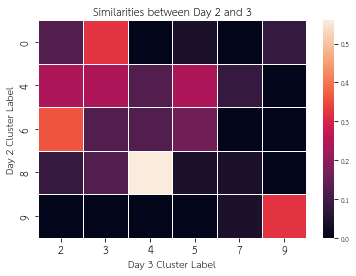

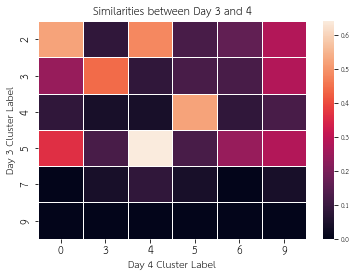

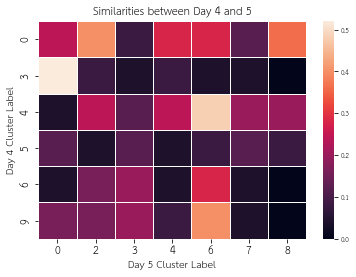

In [81]:
#| output: true
allsim_plot(sim_time_expand, topics_time_expand)

In [82]:
# check if topics evolve or any new topic occurs

In [83]:
## **documents based similarities (too much calculation time)**

In [84]:
# check similarities if topics is evolved

In [85]:
# assume that the most similar topic of cluster[i-1] and cluster[i] is evolve from each other 

# **Topic Coherence**

In [86]:
from gensim.models.coherencemodel import CoherenceModel

In [87]:
def cal_coherence(topics_set, corpus_set, dictionary_set, original_text):
    coherences_result = {}
    for i in ['u_mass', 'c_v', 'c_uci', 'c_npmi']:
      cm = CoherenceModel(topics = topics_set, corpus = corpus_set, dictionary = dictionary_set, coherence=i, texts = original_text)
      coherences_result[i] = cm.get_coherence()
      # print(f"{i} coherence: {coherences_result[i]}")
    return coherences_result

In [88]:
def fold_coherence(topics, modeling_results, dictionary):
  coherences = []
  for day in range(len(topics)):
    print(day)
    topic_temp = []
    text_temp = list(map(remove_special, modeling_results[str(day + 1)]['text'].tolist()))
    corpus_temp = [dictionary.doc2bow(doc) for doc in text_temp]
    for top in topics[day]:
      topic = top['feature'].tolist()
      topic_temp.append(topic)
    coherences.append(cal_coherence(topic_temp, corpus_temp, dictionary, text_temp))
  return coherences

In [93]:
# non time
# coherences_normal_slide = fold_coherence(topics_normal_slide, result_normal_slide, dictionary_tweets2)
# coherences_normal_expand  = fold_coherence(topics_normal_expand, result_normal_expand, dictionary_tweets2)

In [92]:
# coherences_time_slide = fold_coherence(topics_time_slide, result_time_slide, dictionary_tweets2)
# coherences_time_expand = fold_coherence(topics_time_expand, result_time_expand, dictionary_tweets2)

In [94]:
# coherences_time_slide 

In [95]:
# coherences_time_slide_df = pd.json_normalize(coherences_slide)
# coherences_time_expand_df = pd.json_normalize(coherences_expand)

In [96]:
coherences_normal_slide_df = pd.read_csv('coherences_newapp/coherences_normal_slide_newapp_45k.csv')
coherences_normal_expand_df = pd.read_csv('coherences_newapp/coherences_normal_expand_newapp_45k.csv')
coherences_time_slide_df = pd.read_csv('coherences_newapp/coherences_time_slide_newapp_45k.csv')
coherences_time_expand_df = pd.read_csv('coherences_newapp/coherences_time_expand_newapp_45k.csv')

In [97]:
coherences_time_expand_df.mean(axis=0)

u_mass   -5.134367
c_v       0.523629
c_uci    -3.624031
c_npmi   -0.062051
k         3.000000
dtype: float64

In [98]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [99]:
def compare_coherence(df, model):
  df["k"] = [i for i in range(1, len(df.index)+1)]
  fig = make_subplots(rows=2, cols=2, subplot_titles=("u_mass coherence", "c_v coherence", \
                                                    "c_uci coherence", "c_npmi coherence"),
                      x_title='Days',
                      y_title='Coherence Score',)
  
  fig.add_trace(go.Scatter(x=df["k"], y=df["u_mass"],
                      mode='lines+markers',
                      name='u_mass'), row = 1, col = 1)
  
  fig.add_trace(go.Scatter(x=df["k"], y=df["c_v"],
                      mode='lines+markers',
                      name='c_v'), row = 1, col = 2)
  
  fig.add_trace(go.Scatter(x=df["k"], y=df["c_uci"],
                      mode='lines+markers',
                      name='c_uci'), row = 2, col = 1)
  
  fig.add_trace(go.Scatter(x=df["k"], y=df["c_npmi"],
                      mode='lines+markers',
                      name='c_npmi'), row = 2, col = 2)
  fig.update_layout(height=500, width=700,
                    title_text=f"{model} Topic Coherence")
  

  fig.show()

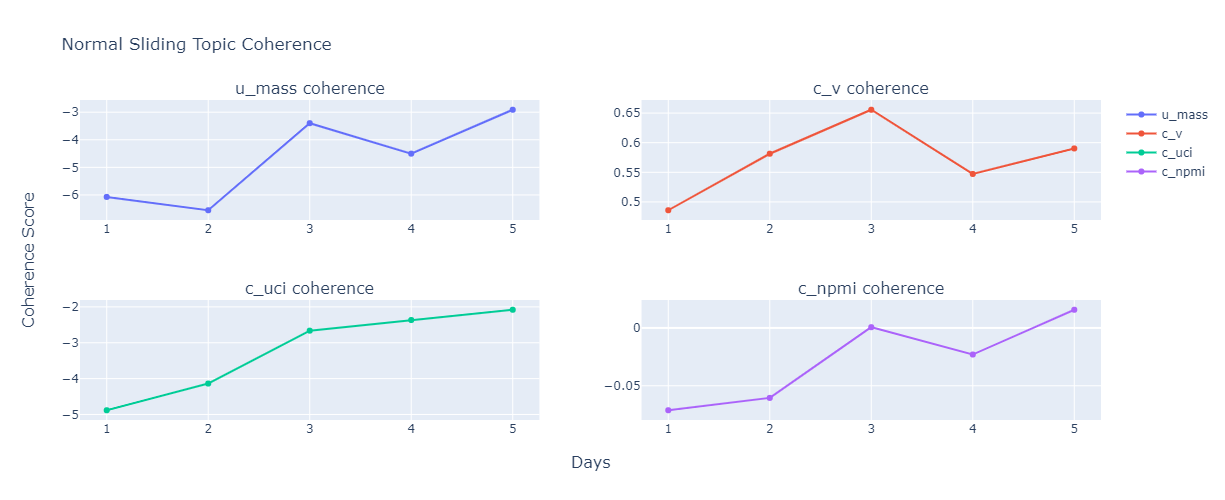

In [104]:
#| output: true 
#| echo: true
compare_coherence(coherences_normal_slide_df, "Normal Sliding")

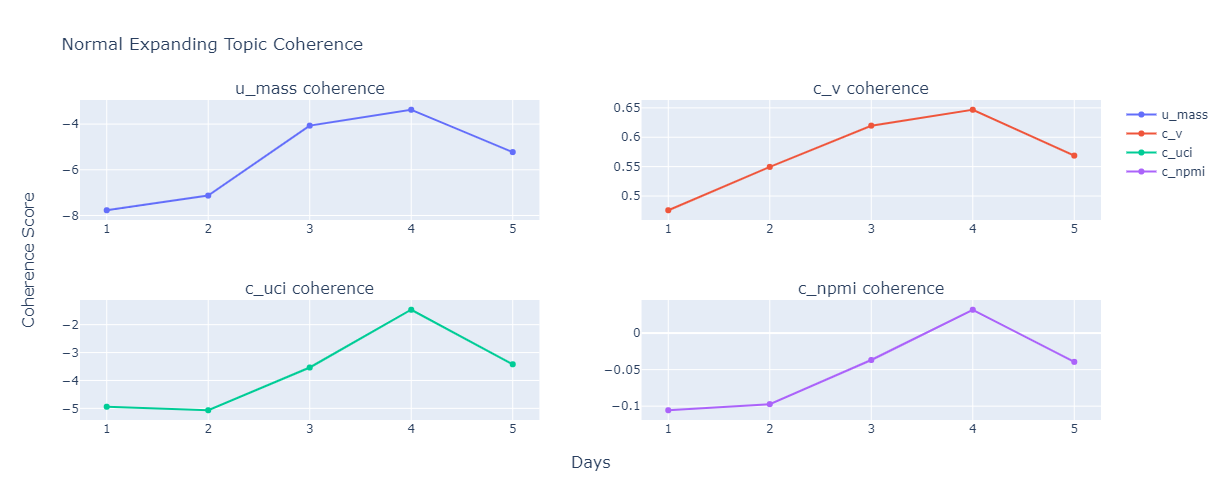

In [105]:
#| output: true 
#| echo: true
compare_coherence(coherences_normal_expand_df, "Normal Expanding")

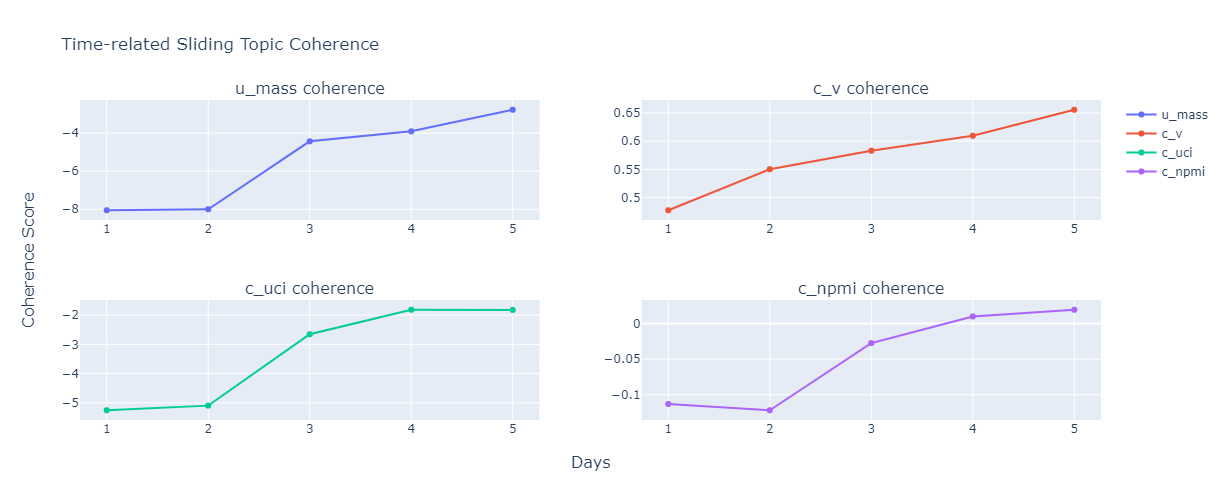

In [106]:
#| output: true 
#| echo: true
compare_coherence(coherences_time_slide_df, "Time-related Sliding")

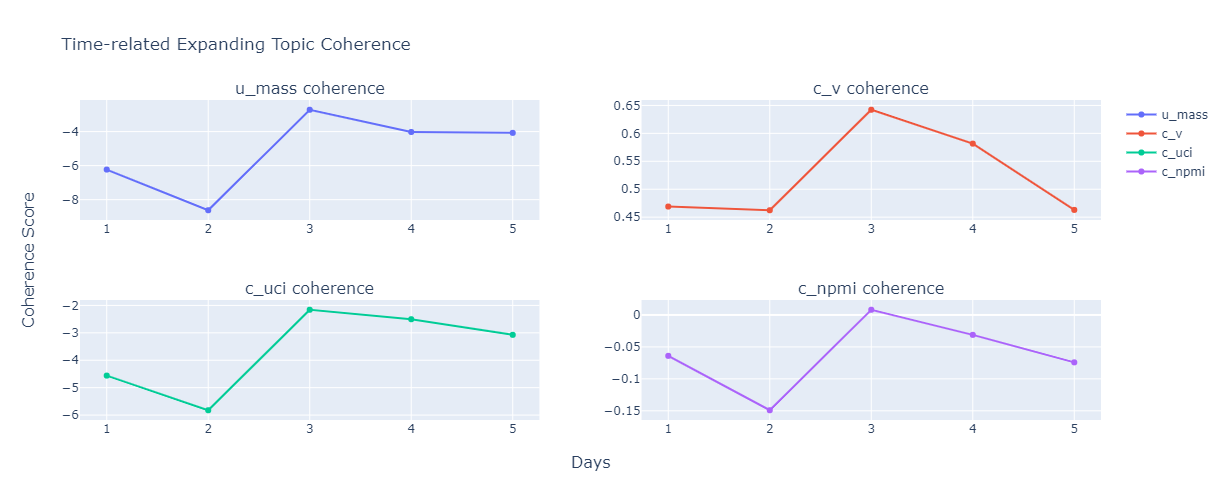

In [107]:
#| output: true 
#| echo: true
compare_coherence(coherences_time_expand_df, "Time-related Expanding")